An overbooking simulation model

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#What-if analysis for overbooking
overbookData = pd.read_excel('data/OverbookingData.xlsx')

#Constants
CAPACITY = 134
TICKETPRICE = 314
TRANSFERFEE = 60 #No shows pay for another flight
BUMPEDCOST = 400


In [5]:
def whatIfSimul(capacity, ticketPrice, 
                transferFee, bumpedCost,
                overbookData,
                simulSize = 10000):
    
    averageDemand  = int(overbookData['Demand'].mean())
    
    showUpRate  = round(overbookData['Rate'].mean(), 2)
    
    overbookingLim = 13 #This parameter can be optimized wrt the net revenue
    
    actualDemand = np.random.poisson(lam = averageDemand, size=simulSize) #The demand follows a poison distribution Use timeseries to
    #TODO: uncover seasonality effects
    
    bookingCapacity = capacity + overbookingLim
    
    booked  = np.array([min(x, bookingCapacity) for x in actualDemand])
    
    readyToBoard = np.array([np.random.binomial(n= x, p= showUpRate) for x in booked])
    
    noShows =booked - readyToBoard
    
    boardingTheFlight = np.array([min(x, capacity) for x in readyToBoard])
    
    bumpedPassengers = readyToBoard - boardingTheFlight
    
    ticketRevenue = booked * ticketPrice
    
    noShowRevenue = transferFee * noShows
    
    overbookingCost = bumpedCost * bumpedPassengers
    
    netRevenue = (ticketRevenue + noShowRevenue) - overbookingCost
    
    
    summarySimul = pd.DataFrame({'stats' : ['mean','std','min','max',
                         'median'],
                 'NetRev' : [netRevenue.mean(),netRevenue.std(),
                             netRevenue.min(), netRevenue.max(),
                             np.median(netRevenue)],
                 'BumpPass' : [bumpedPassengers.mean(),
                               bumpedPassengers.std(),
                               bumpedPassengers.min(),
                               bumpedPassengers.max(),
                               np.median(bumpedPassengers)]})
        
    bumpedPassengersTable =  np.unique(bumpedPassengers, return_counts=True)
    
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(121)
    

    plt.bar(bumpedPassengersTable[0], bumpedPassengersTable[1])
    plt.xlabel('Bumped passengers')
    plt.ylabel('Frequency')
    
    ax = plt.subplot(122)
    plt.hist(netRevenue)
    plt.xlabel('Revenue')
    plt.ylabel('Frequency')
    
    return({'summaryStats': summarySimul,
             'bumbedPass': bumpedPassengers,
             'netRevenue': netRevenue})






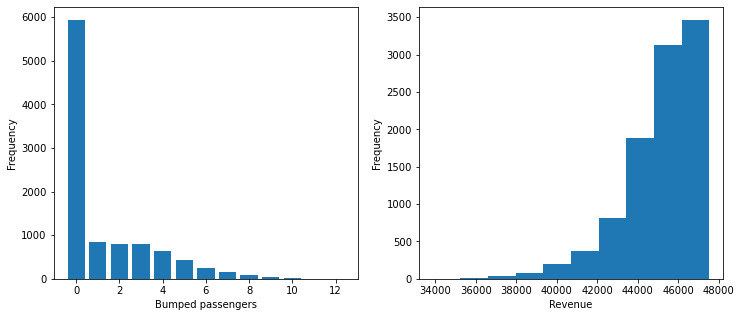

In [7]:
_, bumpedPassengers, netRevenue = whatIfSimul(CAPACITY, TICKETPRICE, 
                                                TRANSFERFEE, BUMPEDCOST,
                                                overbookData,
                                                simulSize = 10000).values()


In [9]:
#Calculate probabilities

lowerThresRevenue = 42000

print(f'Revenue Probability at least {lowerThresRevenue}. : ',
      sum(netRevenue > lowerThresRevenue) / len(netRevenue))

lowerThresBumped = 2

print(f'Bumped passengers at least {lowerThresBumped}. prob.:',
      sum(bumpedPassengers > lowerThresBumped) / len(bumpedPassengers))


Revenue Probability at least 42000. :  0.9324
Bumped passengers at least 2. prob.: 0.2425
